In [1]:
import h2o
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.11" 2021-04-20; OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.20.04); OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.20.04, mixed mode, sharing)
  Starting server from /home/gerd/Documents/Python/venvs/h2o/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpye7asbl4
  JVM stdout: /tmp/tmpye7asbl4/h2o_gerd_started_from_python.out
  JVM stderr: /tmp/tmpye7asbl4/h2o_gerd_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Europe/Vienna
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.2
H2O_cluster_version_age:,1 month and 12 days
H2O_cluster_name:,H2O_from_python_gerd_b3ezs6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.867 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


In [3]:
data = h2o.import_file('http://h2o-public-test-data.s3.amazonaws.com/smalldata/airlines/allyears2k_headers.zip')

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [4]:
train, valid, test = data.split_frame([0.8, 0.1], seed=69)

In [6]:
print("%d/%d/%d" % (train.nrows, valid.nrows, test.nrows))

35255/4272/4451


In [30]:
#
# important to know before training deep learning models:
#
# the cardinality of the columns greatly affects how long the model takes
# you can find out if theres columns with high cardinality by running:
train.nlevels()
#
# as can be seen there is a column which has 3501 different categories in it, meaning the model generation process 
# will take up way more time than it would without it. 
# Always inspect these columns and see whether it is worth to filter them out first.
# train.structure() helps here.
#
# In this case the column is "Tailnum" and its not really containing valuable information, which means we can drop it and save time.
#

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 10,
 0,
 3501,
 0,
 0,
 0,
 0,
 0,
 132,
 134,
 0,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2]

In [7]:
allColumns = data.columns
allColumns.remove("ArrDelay")

specificColumns = data.columns
specificColumns.remove("UniqueCarrier")
specificColumns.remove("TailNum")
specificColumns.remove("TaxiIn")
specificColumns.remove("TaxiOut")
specificColumns.remove("ArrDelay")

targetColumn = "IsArrDelayed"

In [32]:
from h2o.estimators.deeplearning import H2ODeepLearningEstimator

model = H2ODeepLearningEstimator()
%time model.train(specificColumns, targetColumn, train, validation_frame=valid)

deeplearning Model Build progress: |██████████████████████████████████████| 100%
CPU times: user 343 ms, sys: 41.4 ms, total: 384 ms
Wall time: 28.7 s


In [33]:
model.model_performance(test)


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.01835490290316032
RMSE: 0.13548026757856776
LogLoss: 0.060570302656803805
Mean Per-Class Error: 0.023107782528014376
AUC: 0.9978735685213094
AUCPR: 0.9983687997027914
Gini: 0.9957471370426187

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6562821655831276: 


,,NO,YES,Error,Rate
0,NO,1909.0,41.0,0.021,(41.0/1950.0)
1,YES,63.0,2438.0,0.0252,(63.0/2501.0)
2,Total,1972.0,2479.0,0.0234,(104.0/4451.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.656282,0.979116,165.0
1,max f2,0.133472,0.985520,292.0
2,max f0point5,0.770441,0.984718,128.0
3,max accuracy,0.656282,0.976634,165.0
4,max precision,0.999999,1.000000,0.0
5,max recall,0.003055,1.000000,385.0
6,max specificity,0.999999,1.000000,0.0
7,max absolute_mcc,0.656282,0.952648,165.0
8,max min_per_class_accuracy,0.627046,0.975610,171.0
9,max mean_per_class_accuracy,0.656282,0.976892,165.0



Gains/Lift Table: Avg response rate: 56.19 %, avg score: 56.56 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.177713,1.000000e+00,1.779688,1.779688,1.000000,1.000000e+00,1.000000,1.000000,0.316273,0.316273,77.968812,77.968812,0.316273
1,2,0.200854,1.000000e+00,1.779688,1.779688,1.000000,1.000000e+00,1.000000,1.000000,0.041184,0.357457,77.968812,77.968812,0.357457
2,3,0.300157,1.000000e+00,1.779688,1.779688,1.000000,1.000000e+00,1.000000,1.000000,0.176729,0.534186,77.968812,77.968812,0.534186
3,4,0.400135,9.999929e-01,1.779688,1.779688,1.000000,9.999991e-01,1.000000,1.000000,0.177929,0.712115,77.968812,77.968812,0.712115
4,5,0.500112,9.904529e-01,1.767690,1.777290,0.993258,9.985168e-01,0.998652,0.999703,0.176729,0.888844,76.769023,77.728962,0.887306
5,6,0.600090,7.701731e-02,1.087809,1.662419,0.611236,6.436493e-01,0.934107,0.940383,0.108756,0.997601,8.780937,66.241927,0.907345
6,7,0.700067,2.796155e-04,0.023996,1.428434,0.013483,1.240914e-02,0.802632,0.807858,0.002399,1.000000,-97.600421,42.843389,0.684615
7,8,0.800045,9.741659e-07,0.000000,1.249930,0.000000,5.128152e-05,0.702331,0.706911,0.000000,1.000000,-100.000000,24.992980,0.456410
8,9,0.900022,2.412466e-09,0.000000,1.111083,0.000000,1.789305e-07,0.624314,0.628385,0.000000,1.000000,-100.000000,11.108337,0.228205
9,10,1.000000,5.813549e-21,0.000000,1.000000,0.000000,2.898857e-10,0.561896,0.565560,0.000000,1.000000,-100.000000,0.000000,0.000000


In [10]:
model

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_model_python_1623344701334_1


Status of Neuron Layers: predicting IsArrDelayed, 2-class classification, bernoulli distribution, CrossEntropy loss, 100,202 weights/biases, 1.2 MB, 352,550 training samples, mini-batch size 1


,,layer,units,type,dropout,l1,l2,mean_rate,rate_rms,momentum,mean_weight,weight_rms,mean_bias,bias_rms
0,,1,297,Input,0.0,,,,,,,,,
1,,2,200,Rectifier,0.0,0.0,0.0,0.136154,0.330891,0.0,-0.000017,0.068016,0.027997,0.164213
2,,3,200,Rectifier,0.0,0.0,0.0,0.257068,0.33181,0.0,-0.021462,0.092604,0.456185,0.202255
3,,4,2,Softmax,,0.0,0.0,0.033803,0.102362,0.0,-0.011489,0.326769,0.005656,0.048347




ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.020783531737640352
RMSE: 0.14416494628598295
LogLoss: 0.0677333016289188
Mean Per-Class Error: 0.023415036572261405
AUC: 0.9981627617724771
AUCPR: 0.9985932624384359
Gini: 0.9963255235449542

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.14895854697563288: 


,,NO,YES,Error,Rate
0,NO,4317.0,151.0,0.0338,(151.0/4468.0)
1,YES,80.0,5512.0,0.0143,(80.0/5592.0)
2,Total,4397.0,5663.0,0.023,(231.0/10060.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.148959,0.979476,302.0
1,max f2,0.077975,0.986718,332.0
2,max f0point5,0.487446,0.986134,201.0
3,max accuracy,0.148959,0.977038,302.0
4,max precision,0.999996,1.000000,0.0
5,max recall,0.000005,1.000000,399.0
6,max specificity,0.999996,1.000000,0.0
7,max absolute_mcc,0.148959,0.953518,302.0
8,max min_per_class_accuracy,0.231392,0.975157,272.0
9,max mean_per_class_accuracy,0.298125,0.976585,250.0



Gains/Lift Table: Avg response rate: 55.59 %, avg score: 53.44 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.118489,1.000000e+00,1.798999,1.798999,1.000000,1.000000e+00,1.000000,1.000000,0.213162,0.213162,79.899857,79.899857,0.213162
1,2,0.150099,1.000000e+00,1.798999,1.798999,1.000000,1.000000e+00,1.000000,1.000000,0.056867,0.270029,79.899857,79.899857,0.270029
2,3,0.200000,1.000000e+00,1.798999,1.798999,1.000000,1.000000e+00,1.000000,1.000000,0.089771,0.359800,79.899857,79.899857,0.359800
3,4,0.300000,9.999998e-01,1.798999,1.798999,1.000000,1.000000e+00,1.000000,1.000000,0.179900,0.539700,79.899857,79.899857,0.539700
4,5,0.400000,9.995856e-01,1.798999,1.798999,1.000000,9.999349e-01,1.000000,0.999984,0.179900,0.719599,79.899857,79.899857,0.719599
5,6,0.500000,8.909360e-01,1.790057,1.797210,0.995030,9.787972e-01,0.999006,0.995746,0.179006,0.898605,79.005722,79.721030,0.897486
6,7,0.600000,2.319733e-02,0.994278,1.663388,0.552684,3.601492e-01,0.924619,0.889814,0.099428,0.998033,-0.572246,66.338817,0.896198
7,8,0.700000,1.845685e-04,0.017883,1.428316,0.009940,4.904438e-03,0.793951,0.763398,0.001788,0.999821,-98.211731,42.831596,0.675067
8,9,0.800000,1.252643e-06,0.001788,1.250000,0.000994,3.691871e-05,0.694831,0.667978,0.000179,1.000000,-99.821173,25.000000,0.450313
9,10,0.900000,4.688378e-09,0.000000,1.111111,0.000000,2.474851e-07,0.617628,0.593758,0.000000,1.000000,-100.000000,11.111111,0.225157




ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.023729019799760998
RMSE: 0.15404226627702217
LogLoss: 0.08181635230293993
Mean Per-Class Error: 0.027155099864264343
AUC: 0.9969559552401782
AUCPR: 0.9976542295841275
Gini: 0.9939119104803564

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.21665132669741008: 


,,NO,YES,Error,Rate
0,NO,1865.0,68.0,0.0352,(68.0/1933.0)
1,YES,50.0,2289.0,0.0214,(50.0/2339.0)
2,Total,1915.0,2357.0,0.0276,(118.0/4272.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.216651,0.974872,277.0
1,max f2,0.073217,0.982150,329.0
2,max f0point5,0.620519,0.981880,178.0
3,max accuracy,0.339397,0.972378,240.0
4,max precision,0.999997,1.000000,0.0
5,max recall,0.000007,1.000000,399.0
6,max specificity,0.999997,1.000000,0.0
7,max absolute_mcc,0.339397,0.944441,240.0
8,max min_per_class_accuracy,0.289684,0.969995,256.0
9,max mean_per_class_accuracy,0.339397,0.972845,240.0



Gains/Lift Table: Avg response rate: 54.75 %, avg score: 52.64 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.126404,1.000000e+00,1.826422,1.826422,1.000000,1.000000e+00,1.000000,1.000000,0.230868,0.230868,82.642155,82.642155,0.230868
1,2,0.150047,1.000000e+00,1.826422,1.826422,1.000000,1.000000e+00,1.000000,1.000000,0.043181,0.274049,82.642155,82.642155,0.274049
2,3,0.200140,1.000000e+00,1.826422,1.826422,1.000000,1.000000e+00,1.000000,1.000000,0.091492,0.365541,82.642155,82.642155,0.365541
3,4,0.300094,9.999997e-01,1.826422,1.826422,1.000000,1.000000e+00,1.000000,1.000000,0.182557,0.548097,82.642155,82.642155,0.548097
4,5,0.400047,9.990269e-01,1.826422,1.826422,1.000000,9.998522e-01,1.000000,0.999963,0.182557,0.730654,82.642155,82.642155,0.730654
5,6,0.500000,7.873963e-01,1.796480,1.820436,0.983607,9.549386e-01,0.996723,0.990962,0.179564,0.910218,79.648021,82.043608,0.906597
6,7,0.599953,2.132858e-02,0.859744,1.660383,0.470726,3.050576e-01,0.909091,0.876690,0.085934,0.996152,-14.025590,66.038323,0.875614
7,8,0.699906,1.741016e-04,0.034219,1.428152,0.018735,4.648759e-03,0.781940,0.752154,0.003420,0.999572,-96.578133,42.815170,0.662273
8,9,0.799860,1.090491e-06,0.000000,1.249685,0.000000,3.602527e-05,0.684226,0.658167,0.000000,0.999572,-100.000000,24.968498,0.441373
9,10,0.899813,3.538328e-09,0.004277,1.111342,0.002342,1.998909e-07,0.608481,0.585056,0.000428,1.000000,-99.572267,11.134235,0.221417




Scoring History: 


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_r2,...,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_r2,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2021-06-10 19:30:19,0.000 sec,None,0.0,0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2021-06-10 19:30:23,5.924 sec,7682 obs/sec,1.0,1,35255.0,0.278269,0.253097,0.686350,...,0.978108,1.798999,0.091451,0.282715,0.261315,0.677375,0.970062,0.976979,1.826422,0.095974
2,,2021-06-10 19:30:33,15.626 sec,10387 obs/sec,4.0,4,141020.0,0.170281,0.096528,0.882551,...,0.996566,1.798999,0.034990,0.180323,0.112309,0.868750,0.994016,0.995390,1.826422,0.038155
3,,2021-06-10 19:30:44,26.112 sec,10611 obs/sec,7.0,7,246785.0,0.144165,0.067733,0.915815,...,0.998593,1.798999,0.022962,0.154042,0.081816,0.904219,0.996956,0.997654,1.826422,0.027622
4,,2021-06-10 19:30:54,36.324 sec,10749 obs/sec,10.0,10,352550.0,0.165649,0.095052,0.888854,...,0.998971,1.798999,0.018986,0.181285,0.112308,0.867345,0.997329,0.997840,1.826422,0.027856
5,,2021-06-10 19:30:55,36.975 sec,10747 obs/sec,10.0,10,352550.0,0.144165,0.067733,0.915815,...,0.998593,1.798999,0.022962,0.154042,0.081816,0.904219,0.996956,0.997654,1.826422,0.027622



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,ActualElapsedTime,1.000000,1.000000,0.016432
1,CRSElapsedTime,0.805836,0.805836,0.013241
2,DepDelay,0.578826,0.578826,0.009511
3,Cancelled,0.459605,0.459605,0.007552
4,Diverted,0.389826,0.389826,0.006405
5,CancellationCode.NA,0.312511,0.312511,0.005135
6,IsDepDelayed.NO,0.253028,0.253028,0.004158
7,Distance,0.252079,0.252079,0.004142
8,Month,0.243769,0.243769,0.004005
9,ArrTime,0.239140,0.239140,0.003929



See the whole table with table.as_data_frame()


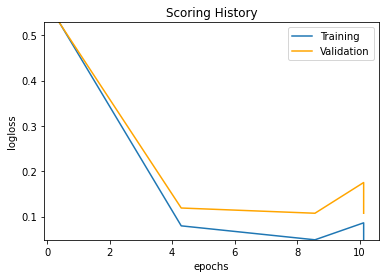

In [25]:
model.plot()

In [34]:
model_200_epochs = H2ODeepLearningEstimator(epochs = 200, stopping_rounds = 5, stopping_tolerance = 0, stopping_metric = 'logloss')

%time model_200_epochs.train(specificColumns, targetColumn, train, validation_frame=valid)

deeplearning Model Build progress: |██████████████████████████████████████| 100%
CPU times: user 387 ms, sys: 33 ms, total: 420 ms
Wall time: 1min 35s


In [35]:
model_200_epochs.model_performance(test)


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.01427718339088925
RMSE: 0.11948716831061505
LogLoss: 0.0473547623393377
Mean Per-Class Error: 0.018713950317309047
AUC: 0.9986418765827003
AUCPR: 0.9989745849647338
Gini: 0.9972837531654006

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5284899731674795: 


,,NO,YES,Error,Rate
0,NO,1911.0,39.0,0.02,(39.0/1950.0)
1,YES,45.0,2456.0,0.018,(45.0/2501.0)
2,Total,1956.0,2495.0,0.0189,(84.0/4451.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.528490,0.983187,187.0
1,max f2,0.154095,0.986748,277.0
2,max f0point5,0.778572,0.988786,131.0
3,max accuracy,0.574520,0.981128,178.0
4,max precision,0.999999,1.000000,0.0
5,max recall,0.001754,1.000000,389.0
6,max specificity,0.999999,1.000000,0.0
7,max absolute_mcc,0.574520,0.961728,178.0
8,max min_per_class_accuracy,0.540255,0.980808,183.0
9,max mean_per_class_accuracy,0.574520,0.981286,178.0



Gains/Lift Table: Avg response rate: 56.19 %, avg score: 56.16 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.226466,1.000000e+00,1.779688,1.779688,1.000000,1.000000e+00,1.000000,1.000000,0.403039,0.403039,77.968812,77.968812,0.403039
1,2,0.300157,1.000000e+00,1.779688,1.779688,1.000000,1.000000e+00,1.000000,1.000000,0.131148,0.534186,77.968812,77.968812,0.534186
2,3,0.400135,9.999989e-01,1.779688,1.779688,1.000000,9.999999e-01,1.000000,1.000000,0.177929,0.712115,77.968812,77.968812,0.712115
3,4,0.500112,9.927821e-01,1.779688,1.779688,1.000000,9.992382e-01,1.000000,0.999848,0.177929,0.890044,77.968812,77.968812,0.890044
4,5,0.600090,4.622410e-02,1.067813,1.661087,0.600000,6.102860e-01,0.933358,0.934945,0.106757,0.996801,6.781287,66.108667,0.905519
5,6,0.700067,4.645662e-06,0.031994,1.428434,0.017978,5.467722e-03,0.802632,0.802205,0.003199,1.000000,-96.800561,42.843389,0.684615
6,7,0.800045,5.895628e-10,0.000000,1.249930,0.000000,4.923788e-07,0.702331,0.701958,0.000000,1.000000,-100.000000,24.992980,0.456410
7,8,0.900022,3.375618e-14,0.000000,1.111083,0.000000,7.733028e-11,0.624314,0.623982,0.000000,1.000000,-100.000000,11.108337,0.228205
8,9,1.000000,7.171661e-40,0.000000,1.000000,0.000000,2.728541e-15,0.561896,0.561598,0.000000,1.000000,-100.000000,0.000000,0.000000


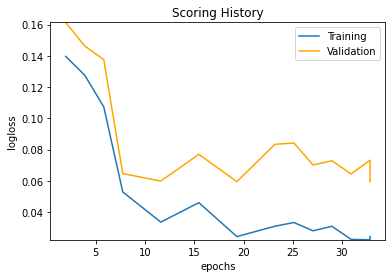

In [36]:
model_200_epochs.plot()

In [29]:
model_200_epochs

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_model_python_1623344701334_135


Status of Neuron Layers: predicting IsArrDelayed, 2-class classification, bernoulli distribution, CrossEntropy loss, 803,202 weights/biases, 9.3 MB, 1,662,051 training samples, mini-batch size 1


,,layer,units,type,dropout,l1,l2,mean_rate,rate_rms,momentum,mean_weight,weight_rms,mean_bias,bias_rms
0,,1,3812,Input,0.0,,,,,,,,,
1,,2,200,Rectifier,0.0,0.0,0.0,0.463673,0.47204,0.0,0.000043,0.024559,-0.104332,0.172755
2,,3,200,Rectifier,0.0,0.0,0.0,0.257558,0.347872,0.0,-0.004375,0.100631,0.075185,0.202711
3,,4,2,Softmax,,0.0,0.0,0.040797,0.104636,0.0,0.001974,0.338516,0.02037,0.058541




ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.011961177790426809
RMSE: 0.10936716961879743
LogLoss: 0.04160419045024352
Mean Per-Class Error: 0.015576075242036636
AUC: 0.9991851701880647
AUCPR: 0.9993558275995157
Gini: 0.9983703403761295

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49892348691626226: 


,,NO,YES,Error,Rate
0,NO,4260.0,114.0,0.0261,(114.0/4374.0)
1,YES,32.0,5517.0,0.0058,(32.0/5549.0)
2,Total,4292.0,5631.0,0.0147,(146.0/9923.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.498923,0.986941,182.0
1,max f2,0.447302,0.991672,197.0
2,max f0point5,0.838185,0.989600,89.0
3,max accuracy,0.535544,0.985287,171.0
4,max precision,0.999996,1.000000,0.0
5,max recall,0.154397,1.000000,290.0
6,max specificity,0.999996,1.000000,0.0
7,max absolute_mcc,0.498923,0.970232,182.0
8,max min_per_class_accuracy,0.669974,0.983768,136.0
9,max mean_per_class_accuracy,0.535544,0.984424,171.0



Gains/Lift Table: Avg response rate: 55.92 %, avg score: 56.96 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.173738,1.000000e+00,1.788250,1.788250,1.000000,1.000000e+00,1.000000,1.000000,0.310687,0.310687,78.825014,78.825014,0.310687
1,2,0.200040,1.000000e+00,1.788250,1.788250,1.000000,1.000000e+00,1.000000,1.000000,0.047036,0.357722,78.825014,78.825014,0.357722
2,3,0.300010,1.000000e+00,1.788250,1.788250,1.000000,1.000000e+00,1.000000,1.000000,0.178771,0.536493,78.825014,78.825014,0.536493
3,4,0.399980,9.999949e-01,1.788250,1.788250,1.000000,9.999993e-01,1.000000,1.000000,0.178771,0.715264,78.825014,78.825014,0.715264
4,5,0.500050,9.945541e-01,1.786449,1.787890,0.998993,9.990882e-01,0.999798,0.999817,0.178771,0.894035,78.644928,78.788975,0.893806
5,6,0.600020,1.127807e-01,1.059971,1.666611,0.592742,6.727498e-01,0.931979,0.945324,0.105965,1.000000,5.997085,66.661068,0.907407
6,7,0.699990,1.087618e-03,0.000000,1.428592,0.000000,2.379199e-02,0.798877,0.813715,0.000000,1.000000,-100.000000,42.859200,0.680613
7,8,0.799960,8.515200e-06,0.000000,1.250063,0.000000,2.181694e-04,0.699043,0.712053,0.000000,1.000000,-100.000000,25.006299,0.453818
8,9,0.899929,2.842594e-08,0.000000,1.111198,0.000000,1.470121e-06,0.621389,0.632954,0.000000,1.000000,-100.000000,11.119821,0.227023
9,10,1.000000,9.543046e-19,0.000000,1.000000,0.000000,4.221651e-09,0.559206,0.569614,0.000000,1.000000,-100.000000,0.000000,0.000000




ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.026237816992506255
RMSE: 0.16198091551941005
LogLoss: 0.1038250632734234
Mean Per-Class Error: 0.03184524671846756
AUC: 0.9954056223371797
AUCPR: 0.9966009671681102
Gini: 0.9908112446743593

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6491983174083911: 


,,NO,YES,Error,Rate
0,NO,1860.0,73.0,0.0378,(73.0/1933.0)
1,YES,63.0,2276.0,0.0269,(63.0/2339.0)
2,Total,1923.0,2349.0,0.0318,(136.0/4272.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.649198,0.970990,153.0
1,max f2,0.286603,0.979059,252.0
2,max f0point5,0.942085,0.977762,56.0
3,max accuracy,0.652515,0.968165,152.0
4,max precision,0.999998,1.000000,0.0
5,max recall,0.000007,1.000000,399.0
6,max specificity,0.999998,1.000000,0.0
7,max absolute_mcc,0.652515,0.935733,152.0
8,max min_per_class_accuracy,0.695038,0.967926,139.0
9,max mean_per_class_accuracy,0.723230,0.968155,133.0



Gains/Lift Table: Avg response rate: 54.75 %, avg score: 56.39 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.174391,1.000000e+00,1.826422,1.826422,1.000000,1.000000e+00,1.000000,1.000000,0.318512,0.318512,82.642155,82.642155,0.318512
1,2,0.200375,1.000000e+00,1.826422,1.826422,1.000000,1.000000e+00,1.000000,1.000000,0.047456,0.365968,82.642155,82.642155,0.365968
2,3,0.300094,1.000000e+00,1.826422,1.826422,1.000000,1.000000e+00,1.000000,1.000000,0.182129,0.548097,82.642155,82.642155,0.548097
3,4,0.400047,9.999790e-01,1.826422,1.826422,1.000000,9.999974e-01,1.000000,0.999999,0.182557,0.730654,82.642155,82.642155,0.730654
4,5,0.500000,9.703483e-01,1.779371,1.817016,0.974239,9.952979e-01,0.994850,0.999060,0.177854,0.908508,77.937088,81.701582,0.902817
5,6,0.599953,1.509645e-01,0.851189,1.656108,0.466042,6.122612e-01,0.906750,0.934618,0.085079,0.993587,-14.881057,65.610756,0.869945
6,7,0.699906,1.189695e-03,0.051328,1.426930,0.028103,3.100890e-02,0.781271,0.805574,0.005130,0.998717,-94.867199,42.693001,0.660383
7,8,0.799860,5.040035e-06,0.000000,1.248616,0.000000,2.350166e-04,0.683641,0.704936,0.000000,0.998717,-100.000000,24.861596,0.439483
8,9,0.899813,2.165115e-08,0.004277,1.110392,0.002342,9.815502e-07,0.607960,0.626631,0.000428,0.999145,-99.572267,11.039208,0.219528
9,10,1.000000,6.609959e-20,0.008535,1.000000,0.004673,3.654065e-09,0.547519,0.563850,0.000855,1.000000,-99.146532,0.000000,0.000000




Scoring History: 


,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_r2,...,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_r2,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2021-06-10 23:03:21,0.000 sec,None,0.000000,0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2021-06-10 23:03:23,5.218 sec,3046 obs/sec,0.141625,1,4993.0,0.484608,0.766595,0.047263,...,0.925603,1.78825,0.199536,0.480516,0.758172,0.067998,0.891001,0.919838,1.826422,0.197800
2,,2021-06-10 23:03:58,41.354 sec,3974 obs/sec,3.780230,27,133272.0,0.227161,0.166615,0.790655,...,0.996620,1.78825,0.033256,0.252318,0.212384,0.743022,0.990793,0.992610,1.826422,0.051264
3,,2021-06-10 23:04:41,1 min 24.337 sec,3745 obs/sec,7.701319,55,271510.0,0.200684,0.134568,0.836612,...,0.998881,1.78825,0.020054,0.237716,0.213321,0.771904,0.993717,0.995000,1.826422,0.037921
4,,2021-06-10 23:05:22,2 min 5.418 sec,3699 obs/sec,11.487137,82,404979.0,0.109367,0.041604,0.951475,...,0.999356,1.78825,0.014713,0.161981,0.103825,0.894092,0.995406,0.996601,1.826422,0.031835
5,,2021-06-10 23:06:04,2 min 46.646 sec,3703 obs/sec,15.408481,110,543226.0,0.118796,0.046679,0.942748,...,0.999547,1.78825,0.011992,0.178949,0.149386,0.870741,0.994532,0.995861,1.826422,0.036283
6,,2021-06-10 23:06:45,3 min 28.132 sec,3655 obs/sec,19.053609,136,671735.0,0.096820,0.030008,0.961970,...,0.999803,1.78825,0.008062,0.172813,0.133152,0.879453,0.995048,0.995637,1.826422,0.032537
7,,2021-06-10 23:07:29,4 min 12.482 sec,3644 obs/sec,23.101177,165,814432.0,0.083540,0.024124,0.971687,...,0.999742,1.78825,0.008163,0.156519,0.120433,0.901114,0.995669,0.996723,1.826422,0.030197
8,,2021-06-10 23:08:17,5 min 0.155 sec,3643 obs/sec,27.566756,197,971866.0,0.141966,0.077625,0.918236,...,0.999757,1.78825,0.008868,0.199544,0.205677,0.839278,0.994059,0.994637,1.826422,0.031601
9,,2021-06-10 23:09:01,5 min 44.209 sec,3649 obs/sec,31.760289,227,1119709.0,0.108471,0.040722,0.952267,...,0.999906,1.78825,0.005543,0.180151,0.162365,0.869000,0.995845,0.996614,1.826422,0.028324



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,ActualElapsedTime,1.000000,1.000000,0.003259
1,CRSElapsedTime,0.881998,0.881998,0.002874
2,DepDelay,0.562492,0.562492,0.001833
3,Cancelled,0.373444,0.373444,0.001217
4,Distance,0.197614,0.197614,0.000644
5,ArrTime,0.187960,0.187960,0.000613
6,Diverted,0.175416,0.175416,0.000572
7,TaxiOut,0.163820,0.163820,0.000534
8,IsDepDelayed.NO,0.152423,0.152423,0.000497
9,TailNum.NA,0.149266,0.149266,0.000486



See the whole table with table.as_data_frame()


In [17]:
model_200x200x200 = H2ODeepLearningEstimator(epochs=200, hidden = [200, 200, 200])

%time model_200x200x200.train(specificColumns, targetColumn, train, validation_frame=valid)

deeplearning Model Build progress: |██████████████████████████████████████| 100%
CPU times: user 570 ms, sys: 50.1 ms, total: 620 ms
Wall time: 2min 23s


In [18]:
model_200x200x200.model_performance(test)


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.017205911860663278
RMSE: 0.13117130730713664
LogLoss: 0.05784963665491437
Mean Per-Class Error: 0.022442715221603682
AUC: 0.9983625011533848
AUCPR: 0.9987230707202259
Gini: 0.9967250023067695

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4216273298015057: 


,,NO,YES,Error,Rate
0,NO,1896.0,54.0,0.0277,(54.0/1950.0)
1,YES,43.0,2458.0,0.0172,(43.0/2501.0)
2,Total,1939.0,2512.0,0.0218,(97.0/4451.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,4.216273e-01,0.980650,207.0
1,max f2,4.965263e-02,0.988837,311.0
2,max f0point5,9.550884e-01,0.985423,84.0
3,max accuracy,4.216273e-01,0.978207,207.0
4,max precision,9.999998e-01,1.000000,0.0
5,max recall,2.228713e-02,1.000000,340.0
6,max specificity,9.999998e-01,1.000000,0.0
7,max absolute_mcc,4.216273e-01,0.955720,207.0
8,max min_per_class_accuracy,5.729706e-01,0.975610,182.0
9,max mean_per_class_accuracy,4.216273e-01,0.977557,207.0



Gains/Lift Table: Avg response rate: 56.19 %, avg score: 56.26 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.307347,1.000000e+00,1.779688,1.779688,1.000000,1.000000e+00,1.000000,1.000000,0.546981,0.546981,77.968812,77.968812,0.546981
1,2,0.400135,1.000000e+00,1.779688,1.779688,1.000000,1.000000e+00,1.000000,1.000000,0.165134,0.712115,77.968812,77.968812,0.712115
2,3,0.500112,9.978662e-01,1.763691,1.776490,0.991011,9.998507e-01,0.998203,0.999970,0.176329,0.888445,76.369093,77.649012,0.886393
3,4,0.600090,2.292172e-02,1.111805,1.665751,0.624719,6.224031e-01,0.935979,0.937066,0.111156,0.999600,11.180517,66.575077,0.911908
4,5,0.700067,4.768939e-07,0.003999,1.428434,0.002247,2.634161e-03,0.802632,0.803618,0.000400,1.000000,-99.600070,42.843389,0.684615
5,6,0.800045,3.736435e-12,0.000000,1.249930,0.000000,4.005056e-08,0.702331,0.703194,0.000000,1.000000,-100.000000,24.992980,0.456410
6,7,0.900022,1.698448e-18,0.000000,1.111083,0.000000,3.315729e-13,0.624314,0.625081,0.000000,1.000000,-100.000000,11.108337,0.228205
7,8,1.000000,7.493731e-54,0.000000,1.000000,0.000000,8.840267e-20,0.561896,0.562587,0.000000,1.000000,-100.000000,0.000000,0.000000


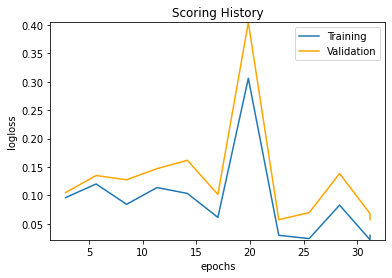

In [19]:
model_200x200x200.plot()

In [20]:
model_400x400 = H2ODeepLearningEstimator(epochs = 200, hidden = [400, 400])

%time model_400x400.train(specificColumns, targetColumn, train, validation_frame=valid)

deeplearning Model Build progress: |██████████████████████████████████████| 100%
CPU times: user 1.35 s, sys: 109 ms, total: 1.46 s
Wall time: 6min 25s


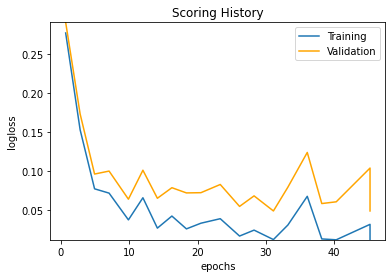

In [21]:
model_400x400.plot()

In [22]:
model_400x400.model_performance(test)


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.010678031338864233
RMSE: 0.10333456023453254
LogLoss: 0.036110385143609335
Mean Per-Class Error: 0.01346835624724474
AUC: 0.9992310768000493
AUCPR: 0.9994147718129893
Gini: 0.9984621536000986

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.445913382294831: 


,,NO,YES,Error,Rate
0,NO,1922.0,28.0,0.0144,(28.0/1950.0)
1,YES,32.0,2469.0,0.0128,(32.0/2501.0)
2,Total,1954.0,2497.0,0.0135,(60.0/4451.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.445913,0.987995,195.0
1,max f2,0.097914,0.990944,274.0
2,max f0point5,0.673558,0.991215,148.0
3,max accuracy,0.445913,0.986520,195.0
4,max precision,0.999999,1.000000,0.0
5,max recall,0.000860,1.000000,391.0
6,max specificity,0.999999,1.000000,0.0
7,max absolute_mcc,0.445913,0.972628,195.0
8,max min_per_class_accuracy,0.451742,0.985641,192.0
9,max mean_per_class_accuracy,0.518393,0.986532,175.0



Gains/Lift Table: Avg response rate: 56.19 %, avg score: 55.86 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.276567,1.000000e+00,1.779688,1.779688,1.000000,1.000000e+00,1.000000,1.000000,0.492203,0.492203,77.968812,77.968812,0.492203
1,2,0.300157,1.000000e+00,1.779688,1.779688,1.000000,1.000000e+00,1.000000,1.000000,0.041983,0.534186,77.968812,77.968812,0.534186
2,3,0.400135,1.000000e+00,1.779688,1.779688,1.000000,1.000000e+00,1.000000,1.000000,0.177929,0.712115,77.968812,77.968812,0.712115
3,4,0.500112,9.988734e-01,1.779688,1.779688,1.000000,9.998762e-01,1.000000,0.999975,0.177929,0.890044,77.968812,77.968812,0.890044
4,5,0.600090,2.798507e-02,1.091809,1.665084,0.613483,5.825239e-01,0.935605,0.930426,0.109156,0.999200,9.180867,66.508447,0.910995
5,6,0.700067,7.707343e-07,0.007999,1.428434,0.004494,3.085497e-03,0.802632,0.797991,0.000800,1.000000,-99.200140,42.843389,0.684615
6,7,0.800045,5.909764e-12,0.000000,1.249930,0.000000,6.556895e-08,0.702331,0.698270,0.000000,1.000000,-100.000000,24.992980,0.456410
7,8,0.900022,6.620077e-18,0.000000,1.111083,0.000000,4.869540e-13,0.624314,0.620704,0.000000,1.000000,-100.000000,11.108337,0.228205
8,9,1.000000,4.247774e-65,0.000000,1.000000,0.000000,2.768419e-19,0.561896,0.558648,0.000000,1.000000,-100.000000,0.000000,0.000000


In [37]:
#
# Compare scorings:
#

models = [model, model_200_epochs, model_200x200x200, model_400x400]
loglosses = map(lambda x: x.logloss(), models)

In [38]:
loglosses